In [ ]:
  install.packages("bnlearn")
install.packages("epiDisplay")
install.packages("caret")
install.packages("bnclassify")
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘entropy’, ‘matrixStats’, ‘BH’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(bnlearn)
library(epiDisplay)
library(bnclassify)
library(e1071)
library(caret)

Loading required package: foreign

Loading required package: survival

Loading required package: MASS

Loading required package: nnet


Attaching package: ‘bnclassify’


The following objects are masked from ‘package:bnlearn’:

    modelstring, narcs, nparams



Attaching package: ‘e1071’


The following object is masked from ‘package:bnlearn’:

    impute


Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:bnclassify’:

    vars


The following object is masked from ‘package:epiDisplay’:

    alpha


Loading required package: lattice


Attaching package: ‘lattice’


The following object is masked from ‘package:epiDisplay’:

    dotplot


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘caret’


The following object is masked from ‘package:survival’:

    cluster




In [ ]:
grades.grades <- read.csv('2020_bn_nb_data.txt', sep = "\t", head = TRUE, stringsAsFactors=TRUE)
grades.courses <- grades.grades[, -9]
head(grades.courses)

In [ ]:
summary(grades.grades)

     EC100        EC160        IT101        IT161        MA101        PH100   
 BC     :48   BC     :59   BC     :49   BC     :49   BC     :54   CC     :40  
 CC     :36   CC     :47   CC     :42   CC     :42   BB     :52   BB     :36  
 BB     :35   CD     :37   CD     :35   BB     :35   CC     :49   BC     :34  
 F      :35   BB     :31   BB     :34   CD     :35   CD     :24   CD     :30  
 CD     :29   DD     :22   AB     :25   AB     :25   DD     :21   AA     :26  
 AB     :22   AB     :16   DD     :23   DD     :23   F      :15   AB     :26  
 (Other):27   (Other):20   (Other):24   (Other):23   (Other):17   (Other):40  
     PH160        HS101    QP     
 BC     :68   AA     :42   n: 72  
 CC     :43   BB     :40   y:160  
 AB     :32   BC     :36          
 BB     :30   AB     :34          
 AA     :27   DD     :29          
 CD     :21   CC     :26          
 (Other):11   (Other):25          

## Part 1: Learning Dependies between the courses

In [ ]:
# Using hill climbing search, we learn dependencies between different grades

### Using k2 score

In [ ]:
grades.hc.k2 <- hc(grades.courses, score = "k2")
grades.hc.k2


  Bayesian network learned via Score-based methods

  model:
   [IT161][IT101|IT161][MA101|IT101][HS101|IT101][EC100|MA101][PH160|HS101]
   [EC160|EC100][PH100|EC100]
  nodes:                                 8 
  arcs:                                  7 
    undirected arcs:                     0 
    directed arcs:                       7 
  average markov blanket size:           1.75 
  average neighbourhood size:            1.75 
  average branching factor:              0.88 

  learning algorithm:                    Hill-Climbing 
  score:                                 Cooper & Herskovits' K2 
  tests used in the learning procedure:  105 
  optimized:                             TRUE 


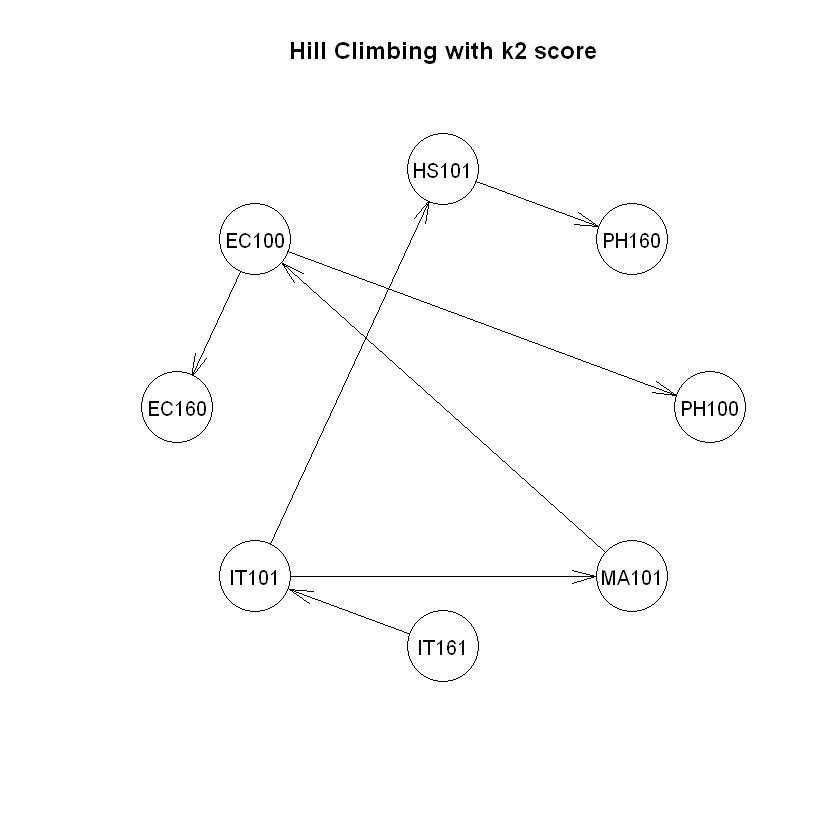

In [ ]:
plot(grades.hc.k2, main = "Hill Climbing with k2 score")

### Using bic score

In [ ]:
grades.hc.bic <- hc(grades.courses, score = "bic")
grades.hc.bic


  Bayesian network learned via Score-based methods

  model:
   [EC100][EC160][IT101][IT161][PH160][HS101][MA101|EC100][PH100|EC100] 
  nodes:                                 8 
  arcs:                                  2 
    undirected arcs:                     0 
    directed arcs:                       2 
  average markov blanket size:           0.50 
  average neighbourhood size:            0.50 
  average branching factor:              0.25 

  learning algorithm:                    Hill-Climbing 
  score:                                 BIC (disc.) 
  penalization coefficient:              2.723369 
  tests used in the learning procedure:  42 
  optimized:                             TRUE 


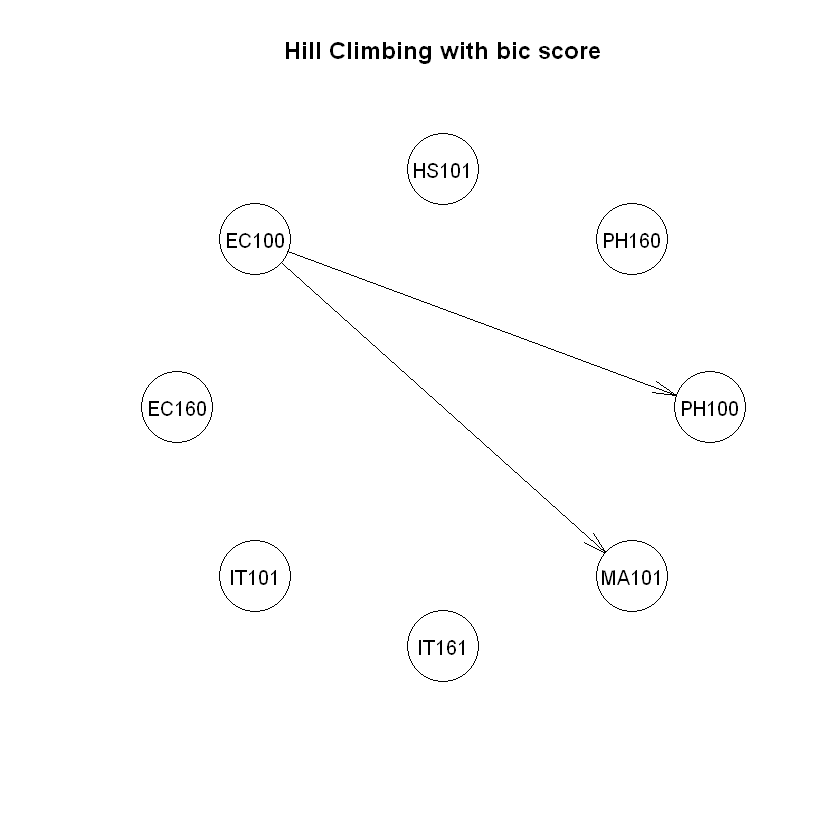

In [ ]:
plot(grades.hc.bic, main = "Hill Climbing with bic score")

## Part 2: Learning the CPTs for each node

In [ ]:
# We'll use the network made using the k2 score, as it represents the the relations better.

In [ ]:
grades.courses.fitted <- bn.fit(grades.hc.k2, grades.courses)

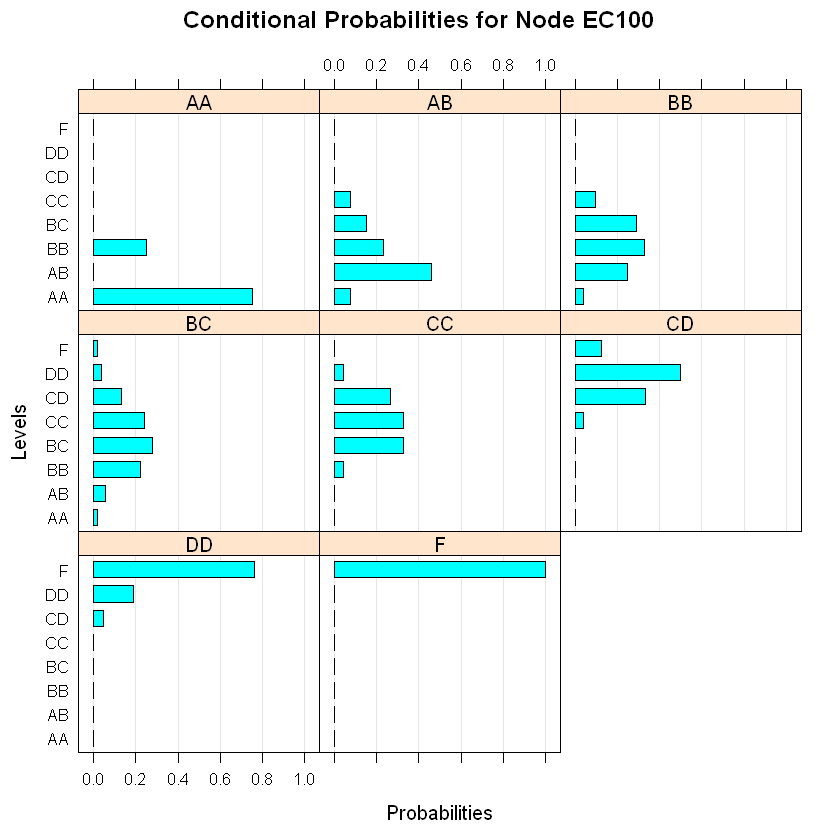

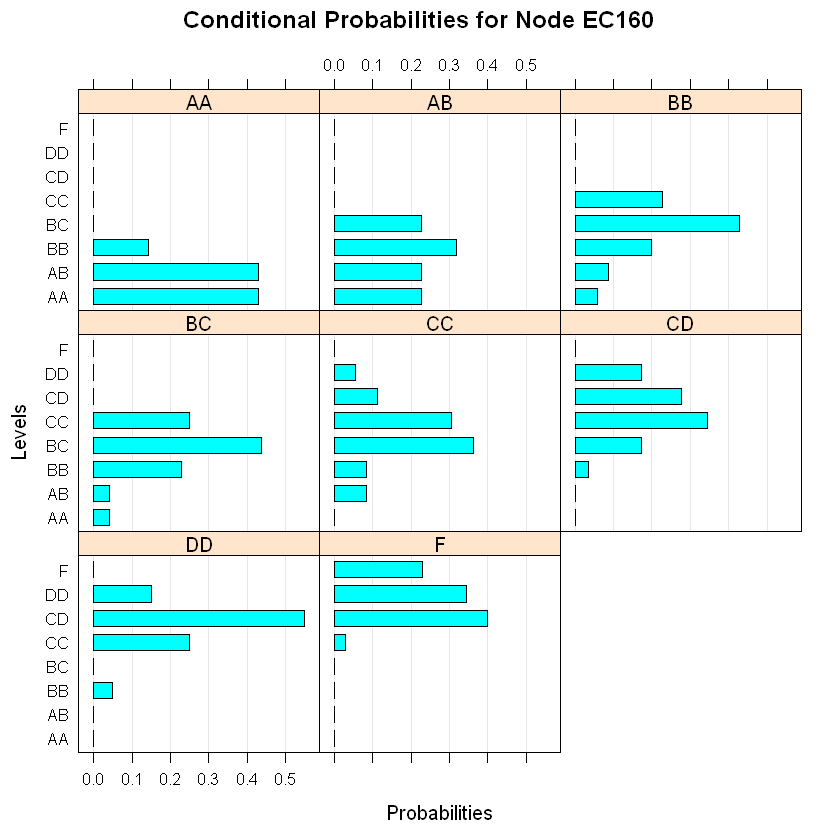

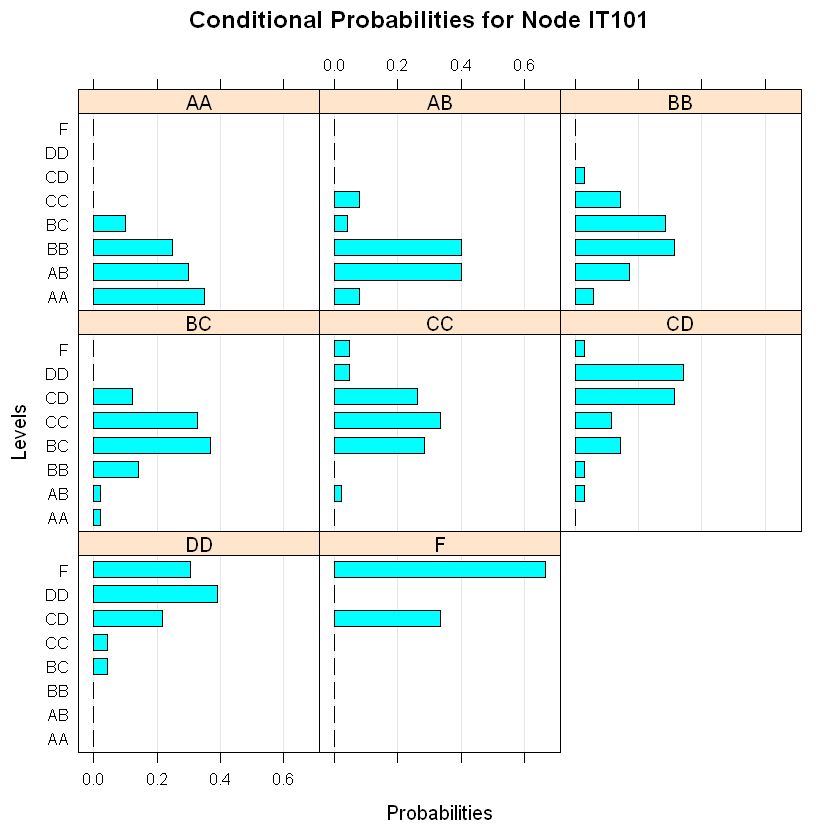

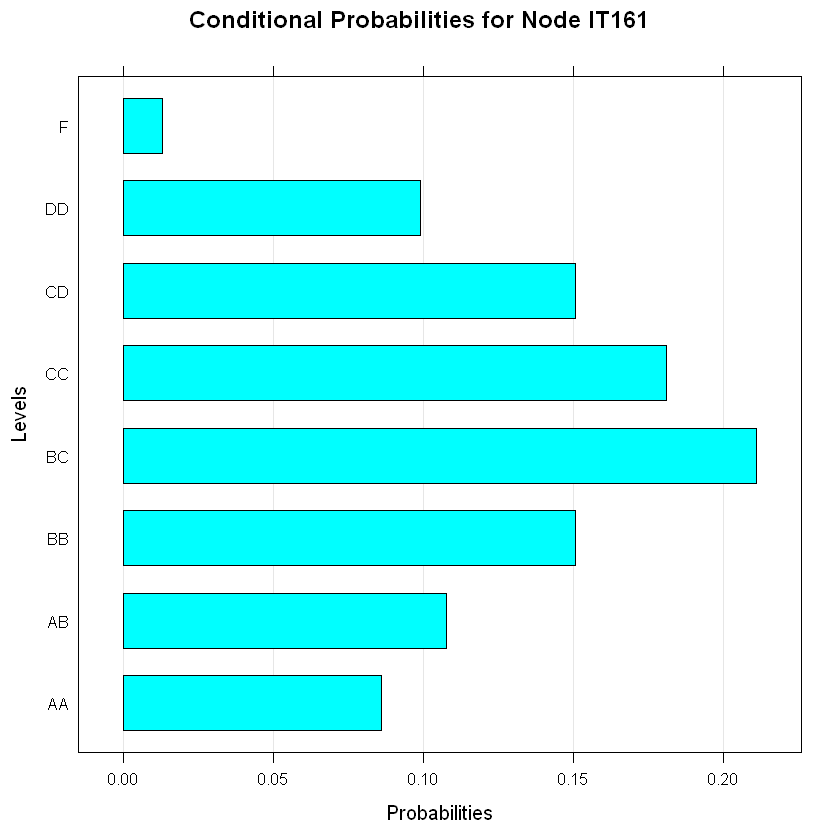

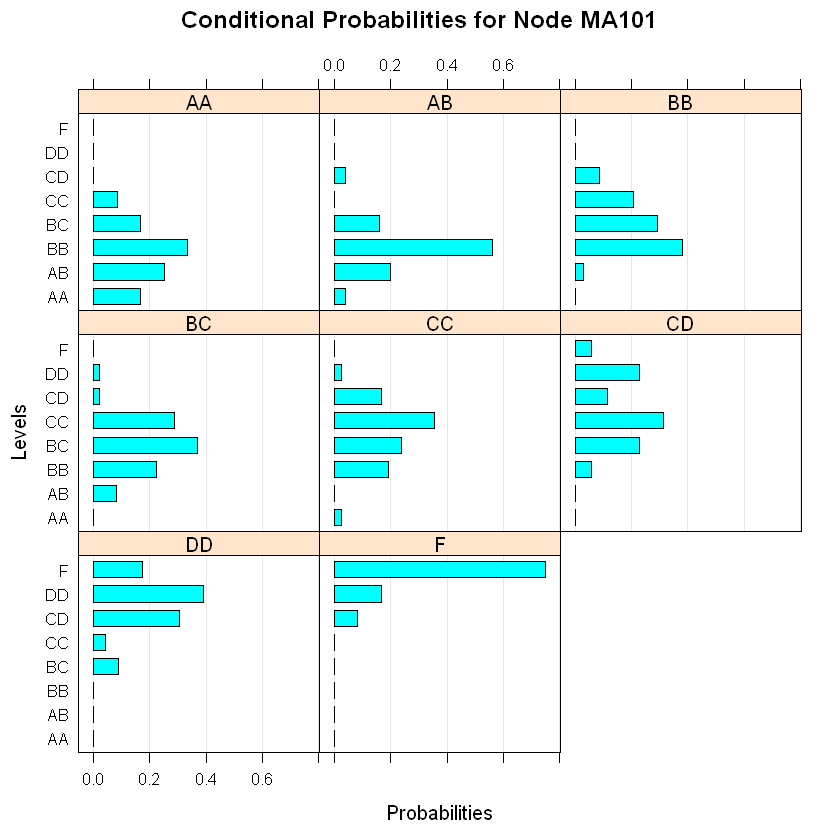

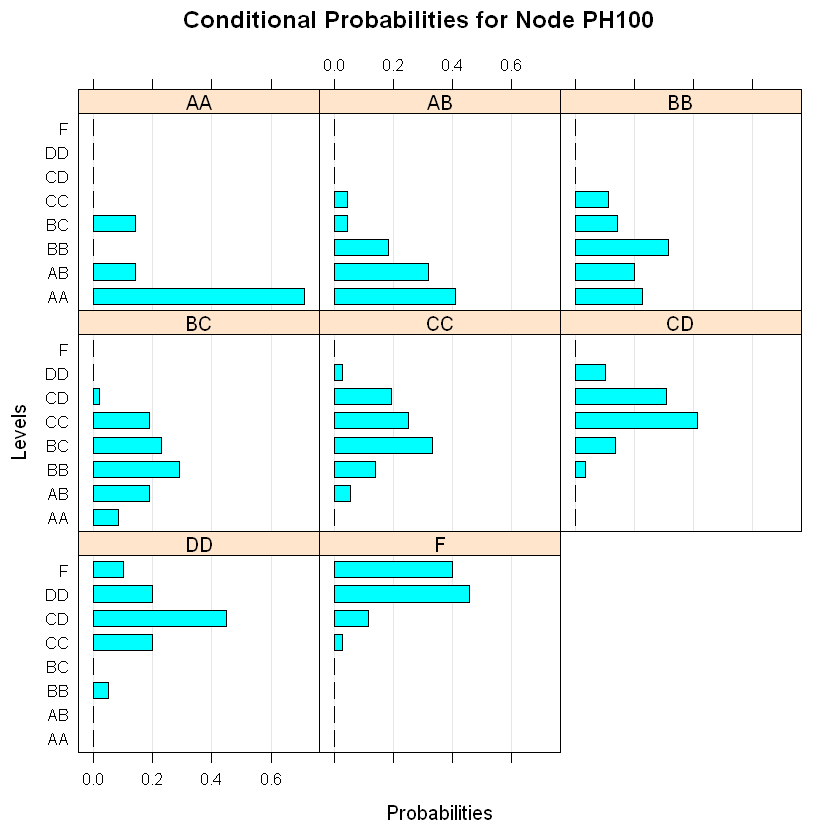

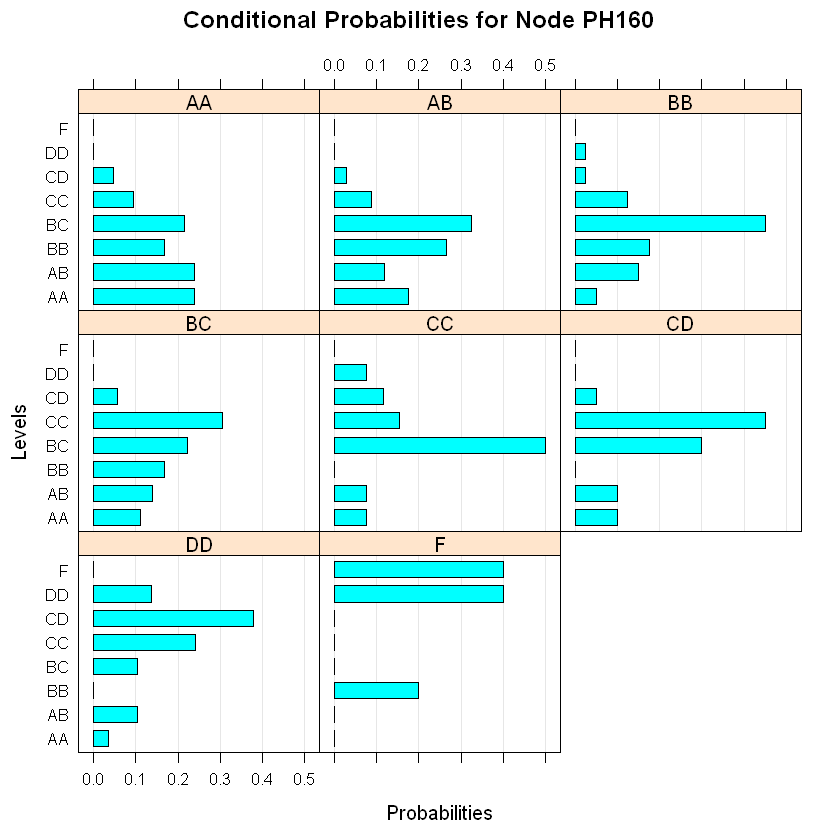

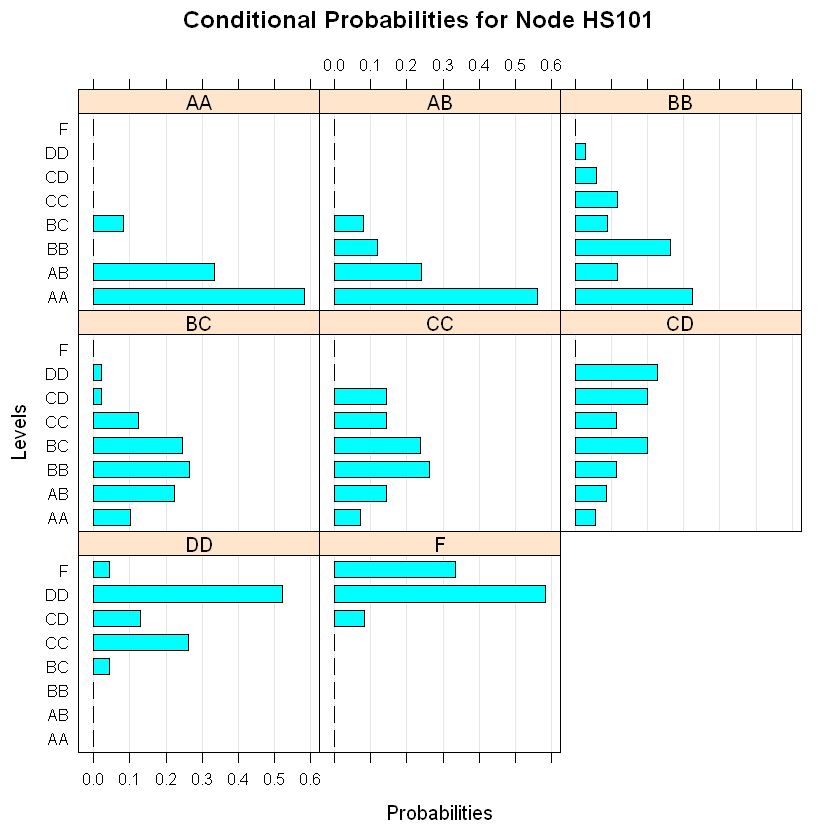

In [ ]:
grades.courses.plots <- lapply(grades.courses.fitted, bn.fit.barchart)

## Part 3: What grade will a student get in PH100 if he earns DD in EC100, CC in IT101 and CD in MA101

,Frequency,Percent,Cum. percent
CD,109,47.2,47.2
DD,48,20.8,68.0
CC,47,20.3,88.3
F,20,8.7,97.0
BB,7,3.0,100.0
BC,0,0.0,100.0
AB,0,0.0,100.0
AA,0,0.0,100.0
Total,231,100.0,100.0


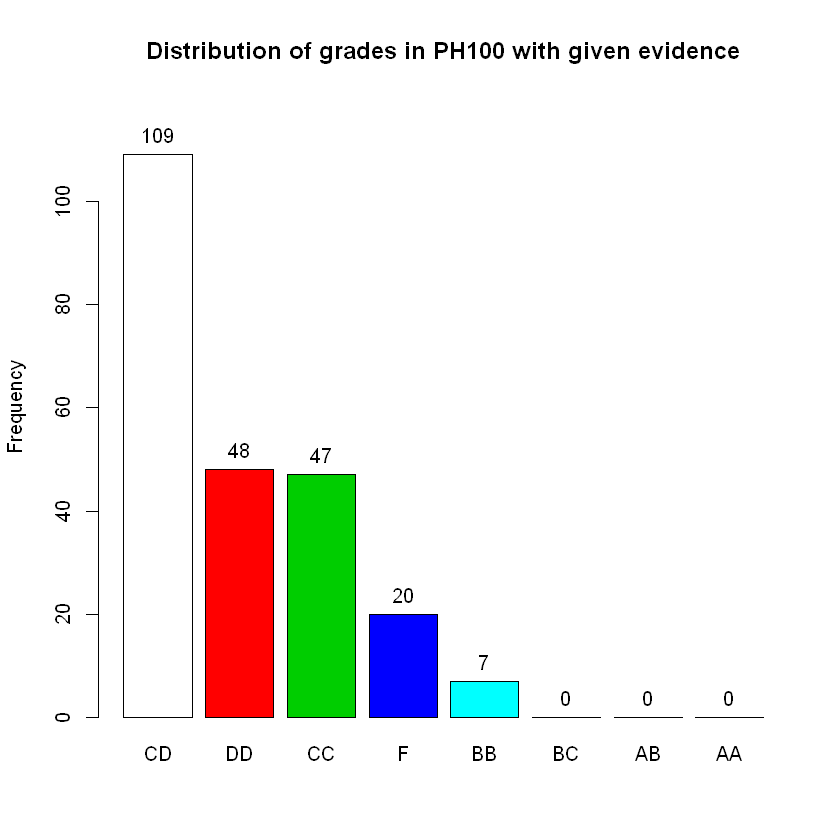

In [ ]:
grades.courses.PH100Grade <- data.frame((cpdist(grades.courses.fitted, nodes=c("PH100"), evidence= (EC100 == "DD") & (IT101 == "CC") & (MA101 == "CD"))))
tab1(grades.courses.PH100Grade, sort.group = "decreasing", main = "Distribution of grades in PH100 with given evidence")

In [ ]:
# Therefore, the student is most likely to earn a CD grade.

## Splitting Data into test and train sets

In [ ]:
split <- sample(c(rep(0, 0.7*nrow(grades.grades)), rep(1, 0.3*nrow(grades.grades))))
table(split)

split
  0   1 
162  69 

In [ ]:
data_train <- grades.grades[split == 0,]
data_test <- grades.grades[split == 1,]
head(data_test)

,EC100,EC160,IT101,IT161,MA101,PH100,PH160,HS101,QP
7,BC,BB,CD,CC,CC,BC,BB,AB,y
9,AA,AB,AA,AA,AA,AA,BB,AB,y
11,BC,BC,BC,BC,BC,BC,BB,BC,y
15,AB,BC,BB,BB,AB,AA,AB,AA,y
16,BC,CC,CD,CC,BB,AA,BB,AA,y
17,CC,BC,CC,BC,BC,AB,BC,AB,y


In [ ]:
 # Putting it all in a function

In [ ]:
split_data <- function() {
  split <- sample(c(rep(0, 0.7*nrow(grades.grades)), rep(1, 0.3*nrow(grades.grades))))
  data_train <- grades.grades[split == 0,]
  data_test <- grades.grades[split == 1,]
  list("data_train" = data_train, "data_test" = data_test)
    }

## Part 4: Naive Bayes classifier for independent data

       n   y
[1,] 0.0 1.0
[2,] 0.5 0.5
[3,] 0.0 1.0
[4,] 0.0 1.0
[5,] 0.0 1.0
[6,] 0.0 1.0


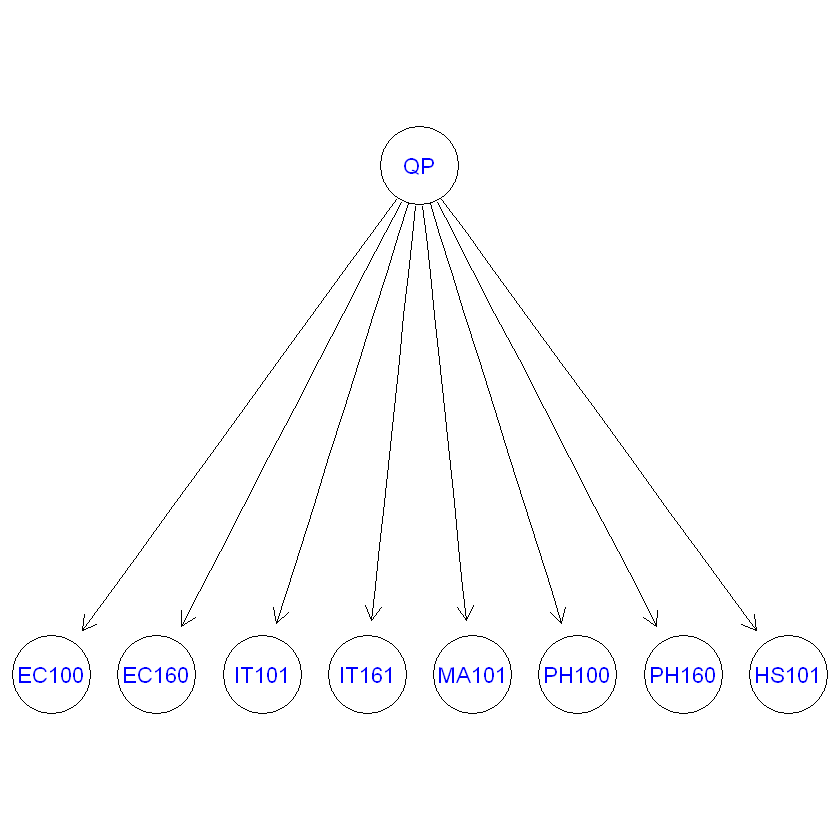

In [ ]:
#making the NB with class with traing dataset
nb.grades_indep <- nb(class = "QP", dataset = data_train)
#learning the parameter
nb.grades_indep <- lp(nb.grades_indep, data_train, smooth = 0)
plot(nb.grades_indep)
#predicting the class with probability with test data
p <- predict(nb.grades_indep,data_test, prob=TRUE)
print(head(p))

In [ ]:
# prdicting the class without probability with test data
p_indep <- predict(nb.grades_indep, data_test)
# confusionMatrix(p_indep, data_test$QP)
cm <- table(predicted=p_indep, true=data_test$QP)
cm

         true
predicted  n  y
        n 12  3
        y  0 54

In [ ]:
#Repeating this 20 times

In [ ]:
for (i in 1:20){
  data <- split_data()
  data_test <- data$data_test
  data_train <- data$data_train
  nb.grades_indep <- nb(class = "QP", dataset = data_train)
  nb.grades_indep <- lp(nb.grades_indep, data_train, smooth = 0)
  p_indep <- predict(nb.grades_indep, data_test)
  print(accuracy(p_indep, data_test$QP))
}

[1] 0.9428571
[1] 0.9855072
[1] 0.9565217
[1] 0.942029
[1] 0.942029
[1] 0.9565217
[1] 0.9855072
[1] 0.9275362
[1] 0.9428571
[1] 0.9710145
[1] 0.9571429
[1] 0.9
[1] 0.9710145
[1] 0.9710145
[1] 0.9130435
[1] 0.9710145
[1] 1
[1] 0.9428571
[1] 0.9710145
[1] 0.9571429


## Part 5: Naive Bayes classifier for dependent data

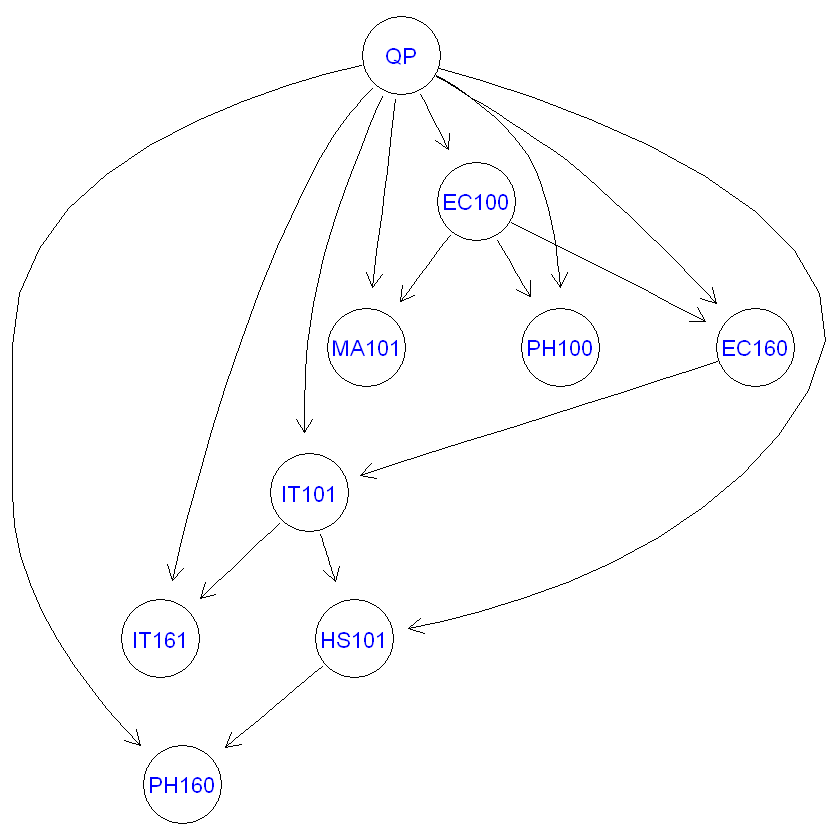

In [ ]:
nb.grades_dep <- tan_cl("QP", data_train)
nb.grades_dep <- lp(nb.grades_dep, data_train, smooth = 1)
plot(nb.grades_dep)

In [ ]:
p_dep <- predict(nb.grades_dep, data_test)
cm <- table(predicted=p_dep, true=data_test$QP)
cm

         true
predicted  n  y
        n 17  2
        y  3 48

In [ ]:
# Repeating this 20 times

In [ ]:
for (i in 1:20){
  data <- split_data()
  data_test <- data$data_test
  data_train <- data$data_train
  nb.grades_dep <- tan_cl("QP", data_train)
  nb.grades_dep <- lp(nb.grades_dep, data_train, smooth = 1)
  p_dep <- predict(nb.grades_dep, data_test)
  print(accuracy(p_dep, data_test$QP))
    }

[1] 0.9710145
[1] 0.9855072
[1] 0.8550725
[1] 0.9130435
[1] 0.8985507
[1] 0.942029
[1] 0.942029
[1] 0.9275362
[1] 0.884058
[1] 0.9710145
[1] 0.9710145
[1] 0.942029
[1] 0.942029
[1] 0.9130435
[1] 0.8985507
[1] 0.942029
[1] 0.9714286
[1] 0.942029
[1] 0.942029
[1] 0.9275362
